In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

sns.set_theme(
    context="paper",
    style="whitegrid",
    rc={
        "figure.figsize": (3.5, 3.5),
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
    },
)


In [6]:
data_path = Path("/nfs/general/mid_data/stats")
filenames = list(data_path.glob("*.npy"))
# filenames = [data_path / "256.npy", data_path / "512.npy"]


def load_scale(filename: Path) -> pd.DataFrame:
    # filename of form {img_size}.npy
    img_size = int(filename.stem)
    data = np.load(filename)
    # columns of data: opt_conn, cnn_conn, cnn_power, opt_count, cnn_count, avg_power
    # keep only the ones relating to cnn
    return pd.DataFrame(
        {
            "img_size": img_size,
            "connectivity": data[:, 1],
            "power": data[:, 2],
            "n_comm": data[:, 4],
        }
    )


df = pd.concat([load_scale(f) for f in filenames], axis=0, ignore_index=True)

# remove values with power == 0
df = df[df["power"] > 0]

df.head()


,img_size,connectivity,power,n_comm
1,768,-4.753953e-17,23.113038,178.0
2,768,-6.193376e-18,16.529586,156.0
3,768,-9.556829e-18,16.187281,163.0
4,768,-1.727234e-17,16.120246,171.0
5,768,-1.792509e-17,18.372750,182.0


In [24]:
display(df.groupby("img_size")["power"].describe()[["mean", "std"]].round(2))
display(df.groupby("img_size")["n_comm"].describe()[["mean", "std"]].round(2))


,mean,std
img_size,,
256,16.60,3.21
512,18.30,4.54
768,18.27,2.71
1024,18.48,2.06
1280,18.03,1.37


,mean,std
img_size,,
256,12.57,3.52
512,68.75,11.30
768,165.79,16.20
1024,308.85,20.70
1280,494.24,27.63


In [ ]:
]meters_per_pixel = 1.25
df["width"] = df["img_size"] * 1.25


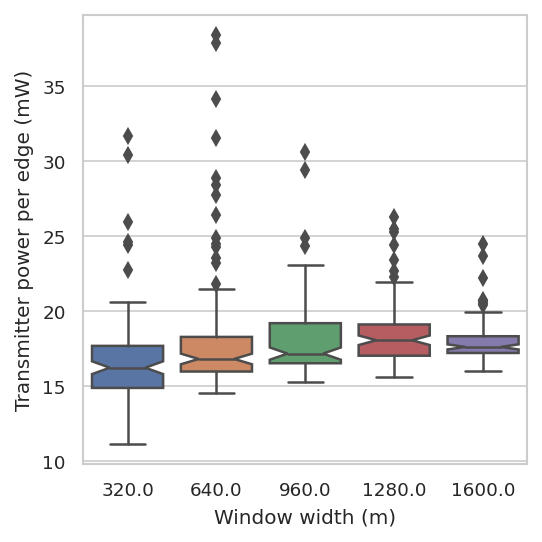

In [ ]:
sns.boxplot(data=df, x="width", y="power", notch=True)
plt.xlabel("Window width (m)")
plt.ylabel("Transmitter power per edge (mW)")
plt.savefig("../figures/mid_power.pdf")
plt.show()
